# Task 01: Selecting earthquakes
* Earthquake events downloaded from the USGS earthquake catalog (https://earthquake.usgs.gov/earthquakes/search/) for the study area (-123 to -125.5 degrees West and 37.5 to 41.5 degrees North), from January 1, 1970 to September 1, 2023 and magnitude 2.0 and above. 
* Subduction interface (between undergoing Juan de Fuca/Gorda plate and overriding North American plate) data called `slab2` is downloded from https://www.sciencebase.gov/catalog/item/5aa312cde4b0b1c392ea3ef5 
* The following codes will select earthquakes that are avobe the interface (i.e., earthquake depth < interface depth) and earthquakes that are within the area covered by the slab2 data (slab2 data is for limited area).
* It will also select earthquakes after January 1, 2008 to Jan 01, 2023

# Part 1: Data selection and preparation

In [372]:
import os

import time
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import pygmt
import urllib.request # to download the data
eq_data_dir = f"{os.getcwd()}/../data/eq_data"

In [373]:
# usgs catalog and slab2 data folder
cat_folder = f"{eq_data_dir}/1_eq_catalogs/"

# get event catalog from USGS catalog
base_url = "https://earthquake.usgs.gov/fdsnws/event/1/query?"

# parameters for the query
format = "csv"
starttime = "2008-01-01"
endtime = "2024-01-01"
minmagnitude = "2"
minlatitude, maxlatitude = "39.75", "41.5"
minlongitude, maxlongitude = "-125.5", "-123"
eventtype = "earthquake"

# build the query
query = f"{base_url}format={format}&starttime={starttime}&endtime={endtime}&minmagnitude={minmagnitude}&"
query += f"minlatitude={minlatitude}&maxlatitude={maxlatitude}&minlongitude={minlongitude}&maxlongitude={maxlongitude}&"
query += f"eventtype={eventtype}"

# save the query to a file
filename = f"usgs_catalog_{starttime}_{endtime}_M{minmagnitude}.csv"

# use python to download the data
if not os.path.exists(f"{cat_folder}/{filename}"):
    urllib.request.urlretrieve(query, f"{cat_folder}/{filename}")
else:
    print(f"File {filename} already exists")

File usgs_catalog_2008-01-01_2024-01-01_M2.csv already exists


In [374]:
t1 = time.time()
cat_file = f"{cat_folder}/{filename}"
# read in the original earthquake data from USGS
eq_df = pd.read_csv(cat_file, parse_dates=['time'])

print(f"No. of events: {len(eq_df)}")

No. of events: 4661


Select the slab2 data that covers out study area.

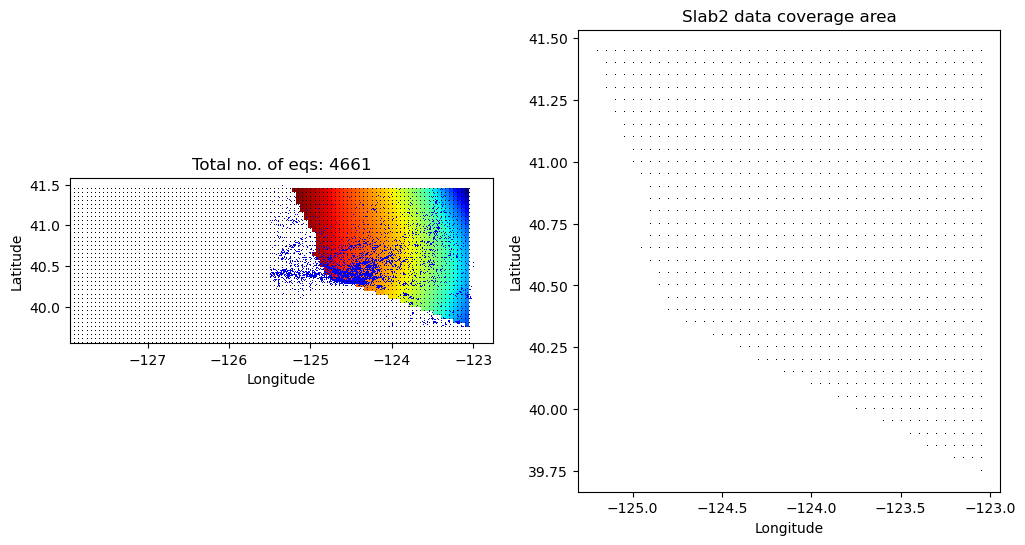

In [375]:
# read the 'slab2' data 
slab2_file = f"{cat_folder}/slab2_subset.csv"
slab2_nonan_file = f"{cat_folder}/slab2_subset_no_nan.csv"

# Load data
slab2_df = pd.read_csv(slab2_file)

# Reshape depth data into a matrix
longitude = slab2_df['lon'].values
latitude = slab2_df['lat'].values
depth = slab2_df['depth_lower'].values

n_longitude = len(np.unique(longitude))
n_latitude = len(np.unique(latitude))
depth_matrix = depth.reshape(n_latitude, n_longitude)

# Create the figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot depth map and data points
ax1.imshow(depth_matrix, cmap='jet', extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()])
ax1.plot(eq_df['longitude'], eq_df['latitude'], 'b,', markersize=0.1)
ax1.plot(slab2_df['lon'], slab2_df['lat'], 'k,', markersize=0.1)
ax1.set_title(f'Total no. of eqs: {len(eq_df)}')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Filter for valid depth locations and plot
slab2_no_nan = slab2_df.dropna()
ax2.plot(slab2_no_nan['lon'], slab2_no_nan['lat'], 'k,', markersize=0.1)
ax2.set_title("Slab2 data coverage area")
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

plt.show()

# Save locations with valid depth values
slab2_no_nan.to_csv(slab2_nonan_file, index=False)


# Part 2: Selecting earthquakes above the plate inrerface
* Intepolate slab depth to the earthquake locations
* Where there is no `slab2` data the interpolated depth will be a `NaN` value, so dropping them will give us earthquakes that are within the area covered by `slab2` data

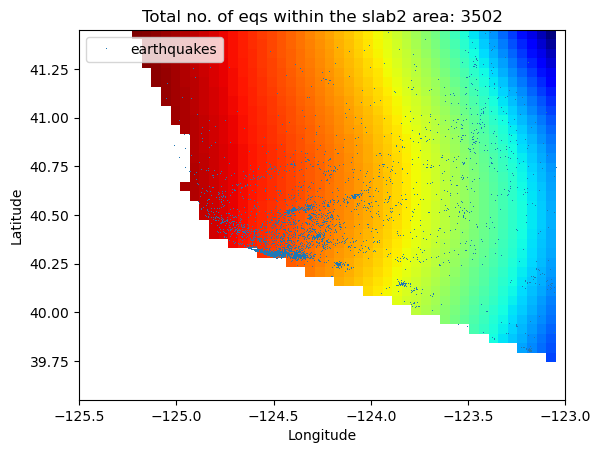

In [376]:
# intepolate slab depth to the earthquake locations
# and add the slab depth to the eq_df as a new column
eq_df['slab_depth'] = griddata(
    (slab2_no_nan['lon'], slab2_no_nan['lat']), 
    slab2_no_nan['depth'], 
    (eq_df['longitude'], eq_df['latitude']), method='linear'
    )

# select earthquakes with slab_depth column is not NaN
eq_in_slab2_area_df = eq_df[~np.isnan(eq_df['slab_depth'])] # ~ means not

# plot the earthquakes on the slab
eq_in_slab2_area_df.plot(x='longitude', y='latitude', marker=',', linestyle='none', label='earthquakes', zorder=2)
# plot the slab
plt.imshow(depth_matrix, cmap='jet', extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()])

plt.title(f'Total no. of eqs within the slab2 area: {len(eq_in_slab2_area_df)}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-125.5, -123)

plt.show()

# write the onslab_eq_df to a csv file
eq_in_slab2_area_df.to_csv(f'{cat_folder}/usgs_eq_in_slab2_area.csv', index=False)

## Get the above slab earthquakes

In [377]:
# make slab_depth column positive because earthquake depth are also positive
eq_in_slab2_area_df.loc[:, 'slab_depth'] = -eq_in_slab2_area_df.slab_depth

# get above slab earthquakes i.e. eq depth < slab depth
above_slab_eq_df = eq_in_slab2_area_df[eq_in_slab2_area_df.depth < eq_in_slab2_area_df.slab_depth]

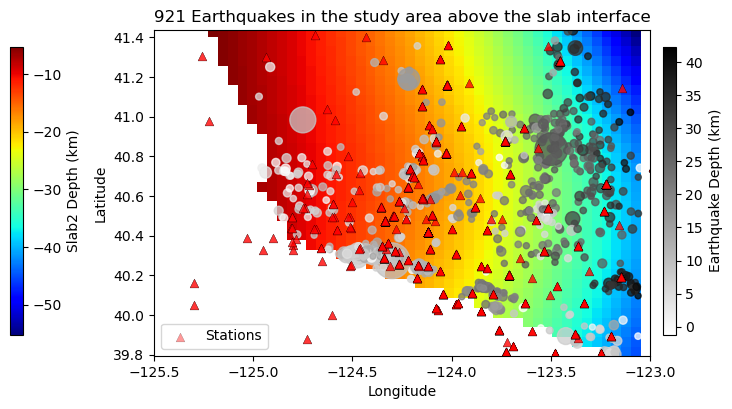

In [378]:
# plot the above_slab_eq_df and slab2_no_nan (as background using plt.imshow)
fig, ax = plt.subplots()



######## plot the slab2 as background ########
ax.imshow(depth_matrix, cmap='jet', extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()])

# add colorbar for slab2 depth
sm1 = plt.cm.ScalarMappable(
    cmap='jet', 
    norm=plt.Normalize(vmin=slab2_no_nan['depth'].min(), vmax=slab2_no_nan['depth'].max())
    )
sm1.set_array([]) # fake the gradient
cax1 = fig.add_axes([-0.1, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
colorbar = fig.colorbar(sm1, cax=cax1, label='Slab2 Depth (km)')



########## plot the earthquakes above the slab ##########
ax.scatter(above_slab_eq_df['longitude'], above_slab_eq_df['latitude'], 
    marker='.', 
    s=np.exp(above_slab_eq_df['mag'])*10, # make markersize proportional to the magnitude
    c=above_slab_eq_df['depth'], 
    cmap='binary', 
    alpha=0.75, 
    label='earthquake depth above the slab'
    )

# add colorbar for earthquake depth
sm2 = plt.cm.ScalarMappable(
    cmap='binary', 
    norm=plt.Normalize(vmin=above_slab_eq_df['depth'].min(), vmax=above_slab_eq_df['depth'].max())
    )
sm2.set_array([])
cax2 = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # adjust position as needed
colorbar2 = fig.colorbar(sm2, cax=cax2, label='Earthquake Depth (km)')



#### Oprional: plot stations on the map as triangles
# read in the station data
station_file = f"{eq_data_dir}/3_station_catalogs/00_station_inventory_master.txt"
station_df = pd.read_csv(station_file, sep='|', header=0, usecols=[4, 5],)

# plot the stations as triangles
ax.scatter(station_df['Longitude'], station_df['Latitude'],
            marker='^', s=40, c='r', label='stations',
            edgecolors='k', linewidths=0.25,
            alpha=0.40
            )

# add stations legend
ax.legend(
    # show only one legend for stations
    [ax.collections[-1]], 
    ['Stations'],
)
# figure titles and others
extent=[above_slab_eq_df.longitude.min(), above_slab_eq_df.longitude.max(), above_slab_eq_df.latitude.min(), above_slab_eq_df.latitude.max()]
ax.set_xlim(-125.5, -123)
ax.set_ylim(extent[2], extent[3])
ax.set_title(f'{len(above_slab_eq_df)} Earthquakes in the study area above the slab interface')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
                        
plt.show()

This figure shows earthquake locations (black dots) that are located (in terms of depth) above the interface between two converging plates. Red-blue color grading clearly shows the depth of the interface increasing to the west. Earthquake magnitude is indicated by the size of the dots and depth by darkness of the dots. Note that the dots are exaggerated to make them more visible.

# Check the result as depth section

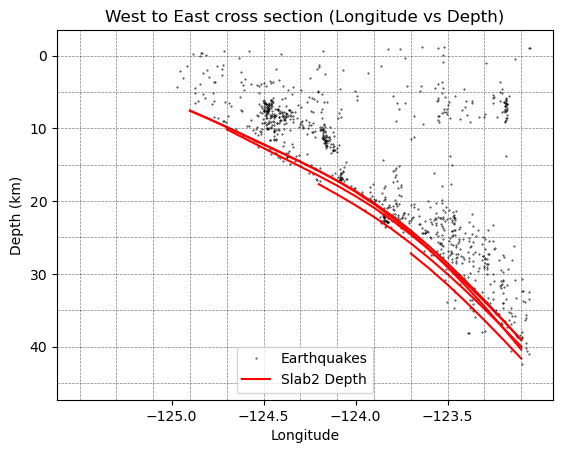

In [379]:
# plot a West to East cross section (Longitude vs Depth)
fig, ax = plt.subplots()

# plot the earthquakes
ax.plot(
    above_slab_eq_df['longitude'], 
    above_slab_eq_df['depth'], 
    '.', 
    color='black',
    markersize=0.75
    )

# plot the slab2 depth at equal interval latitudes from south to north

# Constants for latitude sampling
START_LATITUDE = 40
LATITUDE_SPACING = 0.2
NUM_LATITUDES = 5

# Generate slab depth profiles
longitude_range = np.arange(-128, -123, 0.1)  # Consistent longitude sampling
latitudes = np.arange(START_LATITUDE, (START_LATITUDE + NUM_LATITUDES * LATITUDE_SPACING), LATITUDE_SPACING)

slab_depths = []
for latitude in latitudes:
    grid_points = (longitude_range, [latitude] * len(longitude_range))  # Efficient grid creation
    
    depth_profile = griddata(
        (slab2_no_nan['lon'], slab2_no_nan['lat']),
        slab2_no_nan['depth'],
        grid_points, # lon, lat pairs
        method='linear'
    )

    slab_depths.append(depth_profile) 

# Plot slab depth profiles
for i, slab_depth in enumerate(slab_depths):
    ax.plot(longitude_range, -slab_depth, 'r-')

# plot 5 km depth grids and 0.2 degree longitude grids
for lon in np.arange(-125.5, -123, 0.2):
    ax.axvline(x=lon, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
for depth in np.arange(0, 50, 5):
    ax.axhline(y=depth, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
    
# Axis setup
ax.invert_yaxis()
ax.set_xlabel('Longitude')
ax.set_xticks(np.arange(-125., -123, 0.5))
ax.set_ylabel('Depth (km)')
ax.set_title('West to East cross section (Longitude vs Depth)')
ax.legend(['Earthquakes', 'Slab2 Depth'])

plt.show()

# Divide the study area into grids and select earthquakes within each grid
The purpose here is to select one event from each grid and determine their location accuracy and fault solution (focal mechanism).\
This way I will be able to see how the focal mechanism (a proxy for stress directions) changes from shallowere part of the subduction to the deeper part.

In [380]:
import pandas as pd
import numpy as np

# Define area boundaries and grid sizes
min_lon, max_lon, min_lat, max_lat = -125, -123, 39.75, 41.5
grid_size_lon, grid_size_lat = 0.2, 0.2

# Create grid coordinates and grid codes directly 
lon_grid = np.arange(min_lon, max_lon + grid_size_lon, grid_size_lon)
lat_grid = np.arange(min_lat, max_lat + grid_size_lat, grid_size_lat)
grid_codes = np.arange(1, len(lon_grid) * len(lat_grid) + 1) 

# Create DataFrame of grid codes
grid_df = pd.DataFrame({"grid_code": grid_codes})

# Add grid column to earthquake DataFrame (assuming you have your 'above_slab_eq_df')
above_slab_eq_df = above_slab_eq_df.copy()
above_slab_eq_df['grid_code'] = 0

# Find grid cell indices for each earthquake (vectorized)
lon_indices = np.searchsorted(lon_grid, above_slab_eq_df['longitude']) - 1 
lat_indices = np.searchsorted(lat_grid, above_slab_eq_df['latitude']) - 1 

# Calculate linear indices into the grid
grid_indices = lon_indices * (len(lat_grid) - 1) + lat_indices 

# Assign grid codes efficiently
above_slab_eq_df['grid_code'] = grid_df.iloc[grid_indices]['grid_code'].to_numpy()

above_slab_eq_df= above_slab_eq_df.sort_values(by='grid_code')

# Sort the DataFrame by grid code
gridsort_above_slab_eq_df = above_slab_eq_df.copy()
gridsort_above_slab_eq_df.sort_values(by='grid_code', inplace=True)

# write the above_slab_eq_df to a csv file
gridsort_above_slab_eq_df.to_csv(f'{cat_folder}/usgs_gridsort_eq_in_slab2_area.csv', index=False)

# view the earthquake DataFrame with grid codes
gridsort_above_slab_eq_df.tail()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,slab_depth,grid_code
2575,2015-06-06 11:11:19.130000+00:00,40.803000,-123.097000,32.298,2.32,md,48.0,46.0,0.1712,0.17,...,earthquake,0.36,0.63,0.192,36.0,reviewed,nc,nc,40.548037,87
4618,2008-04-07 21:03:31.130000+00:00,40.767667,-123.129167,38.348,2.11,md,14.0,97.0,0.1279,0.09,...,earthquake,0.45,0.68,0.086,13.0,reviewed,nc,nc,39.248804,87
2238,2016-12-30 05:32:32.890000+00:00,40.840333,-123.198000,27.400,2.07,md,19.0,61.0,0.1811,0.26,...,earthquake,0.74,1.97,0.107,15.0,reviewed,nc,nc,37.815632,87
3735,2011-09-21 06:04:37.870000+00:00,40.973167,-123.155000,40.570,2.23,md,16.0,66.0,0.3180,0.16,...,earthquake,0.46,1.39,0.139,15.0,reviewed,nc,nc,40.777809,88
4535,2008-08-05 02:51:22.840000+00:00,41.021667,-123.098500,42.337,2.14,md,8.0,100.0,0.2315,0.14,...,earthquake,0.61,1.97,0.143,8.0,reviewed,nc,nc,43.468095,88


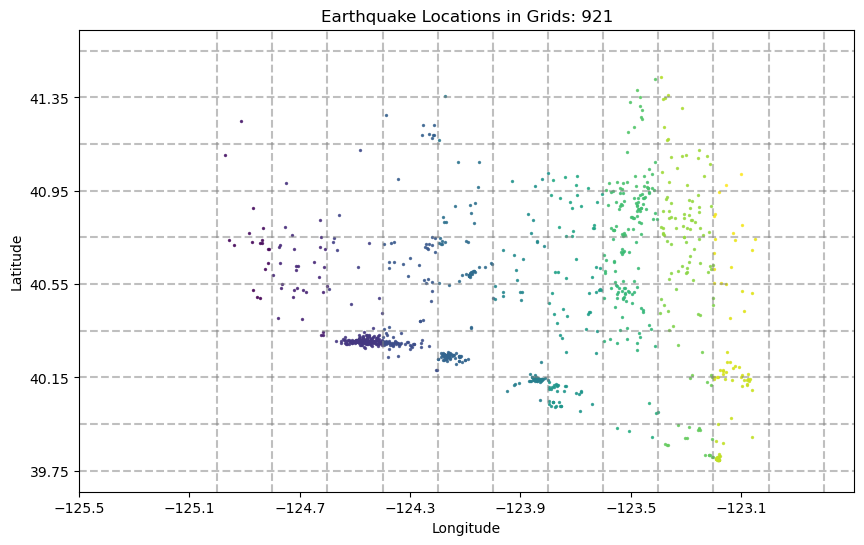

In [381]:
# Extract unique grid codes
unique_grid_codes = above_slab_eq_df['grid_code'].unique()

# Create a colormap for different grid codes
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(unique_grid_codes)))

# Plot the earthquake locations with different colors for each grid
fig, ax = plt.subplots(figsize=(10, 6))

for grid_code in unique_grid_codes:
    grid_earthquakes = above_slab_eq_df[above_slab_eq_df['grid_code'] == grid_code]
    ax.scatter(
        grid_earthquakes['longitude'],
        grid_earthquakes['latitude'],
        color=colors[np.where(unique_grid_codes == grid_code)[0][0]],
        s=2,
        alpha=0.8,
        label=f"Grid {grid_code}",
    )

# Add grid lines
for lon in lon_grid:
    ax.axvline(lon, color="gray", linestyle="--", alpha=0.5)

for lat in lat_grid:
    ax.axhline(lat, color="gray", linestyle="--", alpha=0.5)

# Add labels, title, and legend
ax.set_xticks(np.arange(-125.5, -123, 0.4))
ax.set_yticks(np.arange(39.75, 41.5, 0.4))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title(f"Earthquake Locations in Grids: {len(above_slab_eq_df)}")

plt.show()

# Make 3D grids of the earthquake catalog
0.2 degree x 0.2 degree x 5 km (depth) grid for the catalog


In [382]:
# now assign grid codes to `gridsort_above_slab_eq_df` in a `3D_grid_code` column
# if the earthquake is within the grid
# if not, assign numerical value of 3 digits, such as 111,112 etc

# make 3D grids  for the study area
# Define the area boundaries
min_lon, max_lon, min_lat, max_lat = -125.5, -123, 39.75, 41.5  # [deg]
depth_min, depth_max = 0, 50 # [km]

# Define grid size
grid_size_lon_lat = 0.2  # [deg]
grid_size_depth = 5  # [km]

# Create grid coordinates and grid codes directly
gridsort_above_slab_eq_df['grid_code_3D'] = None

# Loop through each earthquake
for index, row in gridsort_above_slab_eq_df.iterrows():
    lon = row.longitude
    lat = row.latitude
    depth = row.depth

    # Find the corresponding grid cell
    i = int((lon - min_lon) // grid_size_lon_lat)
    j = int((lat - min_lat) // grid_size_lon_lat)
    k = int((depth - depth_min) // grid_size_depth)

    # find the 3D grid code
    grid_code = f"{i+1}{chr(97+j)}{k+1}"
    
    ## Assign the grid code to the earthquake
    gridsort_above_slab_eq_df.loc[index, 'grid_code_3D'] = grid_code

# drop the rows with NaN 3D_grid_code
gridsort_above_slab_eq_df.dropna(subset=['grid_code_3D'], inplace=True)

# write the gridsort_above_slab_eq_df to a csv file
gridsort_above_slab_eq_df.to_csv(f'{cat_folder}/usgs_3D_gridsort_eq_above_slab2_area.csv', index=False)
gridsort_above_slab_eq_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,horizontalError,depthError,magError,magNst,status,locationSource,magSource,slab_depth,grid_code,grid_code_3D
4091,2010-03-01 11:55:48.590000+00:00,40.488833,-124.845667,0.050,2.55,md,27.0,263.0,0.3874,0.35,...,3.60,4.46,0.257,29.0,reviewed,nc,nc,8.243311,4,4d1
3207,2013-09-24 02:56:16.650000+00:00,40.525667,-124.871333,6.589,2.80,md,65.0,265.0,0.4099,0.20,...,0.60,0.99,0.139,57.0,reviewed,nc,nc,7.967011,4,4d2
3741,2011-09-17 17:10:26.520000+00:00,40.494500,-124.854667,6.313,2.14,md,21.0,248.0,0.3946,0.26,...,1.27,2.11,0.338,17.0,reviewed,nc,nc,8.192179,4,4d2
3024,2014-03-10 11:09:10.500000+00:00,40.702333,-124.816500,5.824,2.40,md,32.0,264.0,0.5559,0.27,...,0.77,1.08,0.223,27.0,reviewed,nc,nc,8.465134,5,4e2
3047,2014-03-10 06:39:10.120000+00:00,40.729500,-124.872333,4.394,2.50,md,28.0,301.0,0.6063,0.14,...,1.09,1.05,0.163,21.0,reviewed,nc,nc,7.863408,5,4e1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2015-06-06 11:11:19.130000+00:00,40.803000,-123.097000,32.298,2.32,md,48.0,46.0,0.1712,0.17,...,0.36,0.63,0.192,36.0,reviewed,nc,nc,40.548037,87,13f7
4618,2008-04-07 21:03:31.130000+00:00,40.767667,-123.129167,38.348,2.11,md,14.0,97.0,0.1279,0.09,...,0.45,0.68,0.086,13.0,reviewed,nc,nc,39.248804,87,12f8
2238,2016-12-30 05:32:32.890000+00:00,40.840333,-123.198000,27.400,2.07,md,19.0,61.0,0.1811,0.26,...,0.74,1.97,0.107,15.0,reviewed,nc,nc,37.815632,87,12f6
3735,2011-09-21 06:04:37.870000+00:00,40.973167,-123.155000,40.570,2.23,md,16.0,66.0,0.3180,0.16,...,0.46,1.39,0.139,15.0,reviewed,nc,nc,40.777809,88,12g9


# Make a shaded topo map with earthquakes

In [385]:
topo_data = f"./Mapping/GMRTv4_2_122-128w_39-42.grd"
selected_eq_df = pd.read_csv(f'{cat_folder}/usgs_3D_gridsort_eq_above_slab2_area.csv')

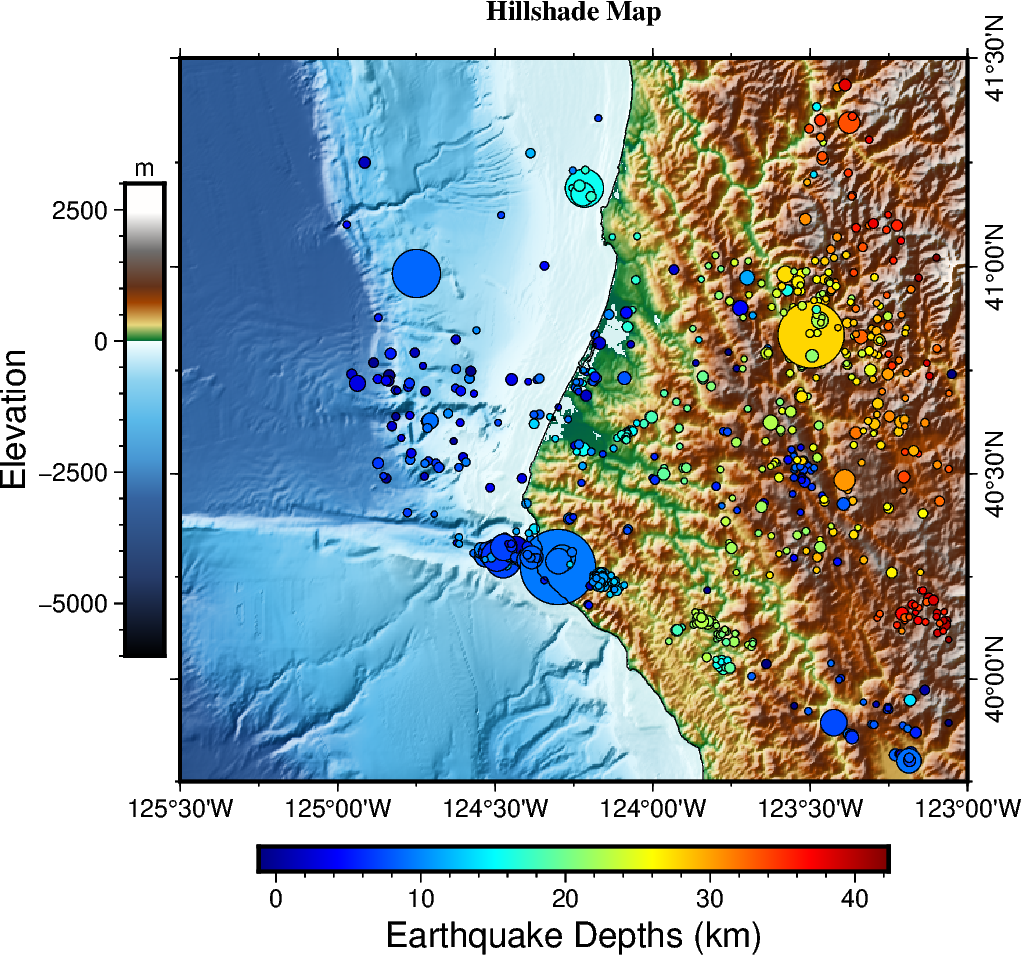

In [415]:
# region=[-128, -122, 39, 42]
region = [-125.5, -123, 39.75, 41.5]

proj="M10c"
azi="0/90"
nor="e1" # normalize the intensity

fig = pygmt.Figure()

# Define color palette
pygmt.makecpt(cmap="geo", series=[-6000, 3000])

# Define figure configuration
with pygmt.config(
    FONT_TITLE="10p,5",
    MAP_TITLE_OFFSET="1p",
    MAP_FRAME_TYPE="plain",
    MAP_ANNOT_OBLIQUE="lat_parallel"
    ):

    # Making an intensity DataArray using azimuth and normalize parameters
    shade = pygmt.grdgradient(grid=topo_data, azimuth=azi, normalize=nor)

    # Plot the topography
    fig.grdimage(
        grid=topo_data,
        region=region,
        projection=proj,
        shading=True,
        frame=['SEnw+tHillshade Map', "xa0.5f0.25", "ya0.5f0.25"],
        cmap=True,
        
        )
        
    # add colorbar
    fig.colorbar(
        position="JML+o0.2c/0c+w6c/0.5c", # +o: offset, +w: width
        # position="x-0.75c/0.75c+w5c/0.5c+m+v+e", # +m: text position, +v: vertical, +e: triangles outside
        frame=["a2500f500+lElevation", "y+lm"]
        )
    
        
    # make a color palette
    pygmt.makecpt(cmap="jet", series=[selected_eq_df.depth.min(), selected_eq_df.depth.max()])

    # plot the selected earthquakes with bigger size [proporional to magnitude]
    fig.plot(
        x=selected_eq_df['longitude'],
        y=selected_eq_df['latitude'],
        size=0.02 * (2 ** selected_eq_df.mag),
        fill=selected_eq_df.depth,
        cmap=True,
        style="cc",
        pen="black",
        # label="Selected Earthquakes",
        )
    # add colorbar for earthquake depths
    fig.colorbar(frame="xaf+lEarthquake Depths (km)")

    # # add legend for the earthquake magnitudes 2-7 [6 circles with different sizes]
    # fig.plot(
    #     x=np.array([-125.5, -125.5, -125.5, -125.5, -125.5, -125.5])-2.1,
    #     y=np.array([40.5, 40.55, 40.65, 40.8, 41.1, 41.6])-1.4,
    #     size=0.1 * (2 ** np.arange(2, 8)),
    #     style="cc",
    #     fill="white",
    #     pen="black",
    #     # label="Magnitude 2-7",
    #     )

    # # add a box to show the selected area
    # fig.plot(
    #     x=[-125.5, -123, -123, -125.5, ],
    #     y=[39.75, 39.75, 41.5, 41.5, ],
    #     pen="0.5p,black",
    #     close=True,
    #     label="Selected Area",
    #     )

    # add coastlines
    fig.coast(region=region, projection=proj, shorelines=True)

    # limit the map to the selected area


fig.show(dpi=200, width=1000)